Load model

In [1]:
import os, torch, sys
import numpy as np
import torch.nn.functional as F
from utils.text_loader import load_vocabs, load_vocabs_from_pairs, write_vocabs, combine_files, get_word2id
from utils.helper import dict2clsattr, check_noun, generate_path
from models.embedding import ClipEmbedding
import argparse, json
import configs
os.environ['TOKENIZERS_PARALLELISM'] = "false"

/home/dthai_umass_edu/miniconda3/envs/pyclip/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from translation import align_words, load_test_dict, train_supervision, cal_similarity, robust_procrustes, get_dico_dict

In [3]:
from matplotlib import pyplot as plt

In [4]:
with open("configs/analysis.json") as f:
    model_config = json.load(f)

args = dict2clsattr({}, model_config)
args.langs = {configs.SRC: args.src_lang, configs.TGT: args.tgt_lang}
# args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args.device = torch.device('cpu')

Load embedding

In [5]:
def load_200k_embeddings(langs, word_data, opts):
    word2ids, vocabs = {}, {}
    embs = {configs.FINGERPRINT: {}, configs.FASTTEXT: {}}
    data_mode = 'full'
    for key, lang in langs.items():
        vocabs[key] = load_vocabs(lang, opts.langs, word_data, data_mode)
        word2ids[key] = get_word2id(vocabs[key])
        for emb_type in [configs.FINGERPRINT, configs.FASTTEXT]:
            embObj = ClipEmbedding(emb_type, lang, data_mode, opts)
            embs[emb_type][key] = torch.Tensor(embObj.load_embedding(vocabs[key])).to(opts.device)
    return word2ids, embs, vocabs

In [6]:
word2ids, embs, vocabs = load_200k_embeddings(args.langs, args.word_data, args)

en fp embedding
..... Reuse emb fp_imagenet_s_wiki_en_ru_en_full_k3
en fasttext embedding
..... Reuse emb fasttext_wiki_en_ru_en_full
ru fp embedding
..... Reuse emb fp_imagenet_s_wiki_en_ru_ru_full_k3
ru fasttext embedding
..... Reuse emb fasttext_wiki_en_ru_ru_full


In [7]:
# test_dico
test_dico = load_test_dict(args, word2ids)
src_ids = []
for i in test_dico[:, 0].numpy():
    if i not in src_ids:
        src_ids.append(i)

src_ids = np.asarray(src_ids) # all 1500 ids
# src_ids = src_ids[filter_ids]
src_id_map = {}
for i in range(len(src_ids)):
    src_id_map[src_ids[i]] = i

src_test_dico = [] # [0, id]
for i in range(len(test_dico)):
    r = test_dico[i].numpy()
    if r[0] in src_ids:
        src_test_dico.append([src_id_map[r[0]], r[1]])
src_test_dico = torch.Tensor(np.asarray(src_test_dico)).type(torch.LongTensor)

In [8]:
# dictionary
d = get_dico_dict(src_test_dico)

In [9]:
fp_embs = {'src':  embs['fp']['src'][src_test_dico[:, 0]], 'tgt': embs['fp']['tgt'][src_test_dico[:, 1]]}
# fp_scores = cal_similarity('csls', np.arange(src_ids.shape[0]), {'src': fp_embs['src'], 'tgt': embs['fp']['tgt']}, 'fp', False) 

In [10]:
X0 = fp_embs['src']
Y0 = fp_embs['tgt']

In [11]:
x1 = embs['fp']['src'][src_ids]
y1 = embs['fp']['tgt'][src_test_dico[:, 1]]

In [12]:
Y0.shape

torch.Size([2447, 2454])

In [13]:
(X0 - Y0).norm(dim=1)

tensor([4.1423, 2.9957, 2.9962,  ..., 2.2639, 2.4623, 2.9107])

In [14]:
X0.norm(dim=1)

tensor([10.3095, 10.3095, 10.1258,  ..., 10.0495,  9.7604,  9.7604])

In [15]:
Y0.norm(dim=1)

tensor([6.7478, 8.3444, 7.7272,  ..., 9.2352, 8.7851, 8.2476])

In [16]:
X0[0, :]

tensor([0.2332, 0.2135, 0.2326,  ..., 0.2215, 0.2357, 0.2159])

In [17]:
X0[3, :]

tensor([0.2254, 0.2066, 0.2263,  ..., 0.2201, 0.2336, 0.2095])

In [18]:
X0[5, :]

tensor([0.2401, 0.2157, 0.2351,  ..., 0.2196, 0.2404, 0.2299])

In [19]:
def hist(X, k):
    x = X[k, :].numpy()
    nums, bins = np.histogram(x, bins=10)
    plt.hist(x, bins)
    plt.show()

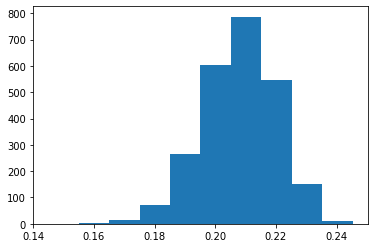

In [20]:
hist(X0, 0)


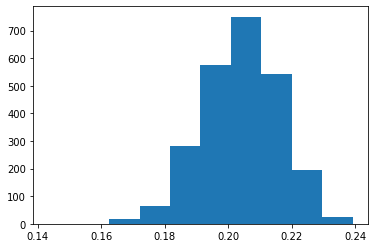

In [21]:
hist(X0, 3)

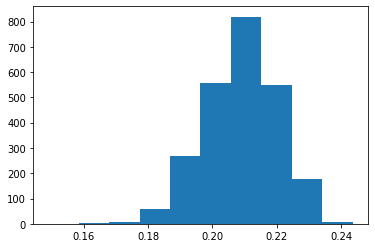

In [22]:
hist(X0, 10)

In [23]:
x2 = (x1 * 20).softmax(dim=1)

In [24]:
y2 = (y1 * 20).softmax(dim=1)

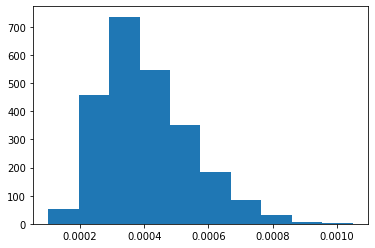

In [25]:
hist(x2, 0)

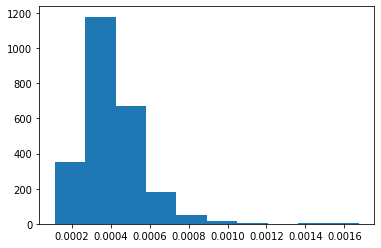

In [26]:
hist(x2, 2)

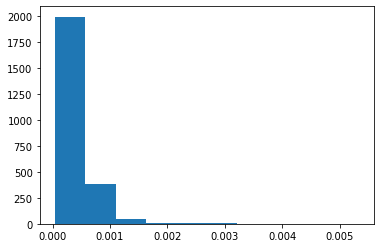

In [27]:
hist(y2, 2)

In [28]:
x0 = (X0 - X0.mean())/X0.std()

In [29]:
y0 = (Y0 - Y0.mean())/Y0.std()

In [30]:
from sklearn.cross_decomposition import CCA

In [31]:
ca = CCA()
ca.fit(x0.numpy(), y0.numpy())
X_c, Y_c = ca.transform(x0.numpy(), y0.numpy())

In [32]:
X_c

array([[-1.32746711e-06,  8.28221012e-06],
       [-1.32746711e-06,  8.28221012e-06],
       [ 4.34347260e-07, -9.76868172e-06],
       ...,
       [ 7.34620479e-06, -2.53462930e-06],
       [ 2.64390383e-06,  7.84680758e-06],
       [ 2.64390383e-06,  7.84680758e-06]])

In [35]:
xc = F.normalize(torch.Tensor(X_c), dim=1)

In [36]:
yc = F.normalize(torch.Tensor(Y_c), dim=1)

In [38]:
s = xc @ yc.T

In [39]:
s.max(dim=1)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]),
indices=tensor([ 725,  725, 1662,  ...,  425,  238,  238]))